In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Télécharger les ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')

# Charger les données
train_df = pd.read_csv('data/train.csv')
game_overview_df = pd.read_csv('data/game_overview.csv')

train_df = train_df.drop(columns=["review_id", "year"], errors='ignore')

# Détection de langue sécurisée
def detect_language_safe(text):
    try:
        return detect(str(text))
    except LangDetectException:
        return "unknown"

# Appliquer la détection de langue
train_df["language"] = train_df["user_review"].apply(detect_language_safe)

# Trouver la langue la plus fréquente
dominant_language = train_df["language"].value_counts().idxmax()
print(f"\nLangue dominante détectée : {dominant_language}")

# Garder uniquement les reviews dans la langue dominante
train_df = train_df[train_df["language"] == dominant_language]

print("Forme du dataset d'entraînement:", train_df.shape)
print("Forme du dataset de jeux:", game_overview_df.shape)

# Afficher les premières lignes de chaque dataframe
print("\nAperçu des données d'entraînement:")
print(train_df.head())

print("\nAperçu des données de jeux:")
print(game_overview_df.head())

# Vérifier les valeurs manquantes
print("\nValeurs manquantes dans le dataset d'entraînement:")
print(train_df.isnull().sum())

print("\nValeurs manquantes dans le dataset de jeux:")
print(game_overview_df.isnull().sum())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Langue dominante détectée : en
Forme du dataset d'entraînement: (17284, 4)
Forme du dataset de jeux: (64, 5)

Aperçu des données d'entraînement:
                         title  \
0  Spooky's Jump Scare Mansion   
1  Spooky's Jump Scare Mansion   
2  Spooky's Jump Scare Mansion   
3  Spooky's Jump Scare Mansion   
4  Spooky's Jump Scare Mansion   

                                         user_review  user_suggestion language  
0  I'm scared and hearing creepy voices.  So I'll...                1       en  
1  Best game, more better than Sam Pepper's YouTu...                1       en  
2  A littly iffy on the controls, but once you kn...                1       en  
3  Great game, fun and colorful and all that.A si...                1       en  
4  Not many games have the cute tag right next to...                1       en  

Aperçu des données de jeux:
                              title                          developer  \
0       Spooky's Jump Scare Mansion                       La

In [17]:
import pandas as pd
import re
import unicodedata
from collections import Counter

def clean_user_review(text):
    if pd.isna(text):
        return ""

    # Convertir en string si ce n'est pas déjà le cas
    text = str(text)

    try:
        # Normaliser Unicode
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    except:
        text = ''.join(c for c in text if c.isprintable())

    # Réduire les répétitions excessives de lettres (ex : aaaaaa -> aa)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Mettre en minuscule
    text = text.lower()

    # Supprimer les liens URL
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)

    # Supprimer les motifs ASCII/émoticônes
    ascii_patterns = [
        r'░+', r'▄+', r'▀+', r'█+',
        r'ヘ\(.*?\)', r'\( ͡° ͜ʖ ͡°\)',
        r'/´¯/.*?/', r'♥+', r'â"€+',
        r'REEEEE+', r'Ohgod(Ohgod)+',
        r'̯.*?͘͠', r'Ẅ̶.*?̈́҉',
    ]
    for pattern in ascii_patterns:
        text = re.sub(pattern, ' ', text)

    # Supprimer mentions inutiles
    text = re.sub(r'\b(early access review|spoiler alert|dev note)\b', ' ', text)

    # Supprimer ponctuation excessive (par exemple, "!!!", "....")
    text = re.sub(r'[\!\?]{2,}', ' ', text)

    # Supprimer les répétitions de groupes de mots
    text = re.sub(r'(\b[\w\s]{1,30}\b)(?:\s*\1){3,}', r'\1', text)

    # Supprimer les répétitions excessives de mots
    words = text.split()
    word_counts = Counter(words)
    filtered_words = [word for word in words if word_counts[word] < 5]
    text = ' '.join(filtered_words)

    # Supprimer les groupes de mots en majuscule de 2+ mots (ex : SHOUTING PHRASE)
    text = re.sub(r'\b(?:[A-Z]{2,}\s+){2,}[A-Z]{2,}\b', '', text)

    # Supprimer caractères non alphanumériques sauf ponctuation simple
    text = re.sub(r'[^\w\s.,!?]', ' ', text)

    # Nettoyer les parenthèses et autres symboles inutiles
    text = re.sub(r'[()\"“”\']', ' ', text)

    # Réduire les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [18]:
print(train_df['user_review'].head(10).tolist())

# Pour voir les types de données
print(train_df.dtypes)

train_df['cleaned_review'] = train_df['user_review'].apply(clean_user_review)

# Afficher exemples avant/après
for i in range(min(10, len(train_df))):
    # print(f"Original: {train_df['user_review'].iloc[i]}")
    print(f"Nettoyé: {train_df['cleaned_review'].iloc[i]}")
    print("-" * 50)

# Vérifier les valeurs uniques après nettoyage
print(train_df['cleaned_review'].value_counts().head(20))

["I'm scared and hearing creepy voices.  So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times.  This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean').  Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd.  I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.", "Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bored.Cons:

C:\Users\User\AppData\Local\Temp\ipykernel_10860\3472153579.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='user_suggestion', palette='coolwarm')


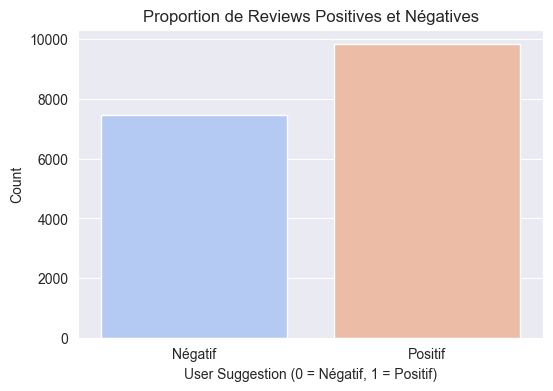

Nombre moyen de mots par commentaire : 113.93086091182596


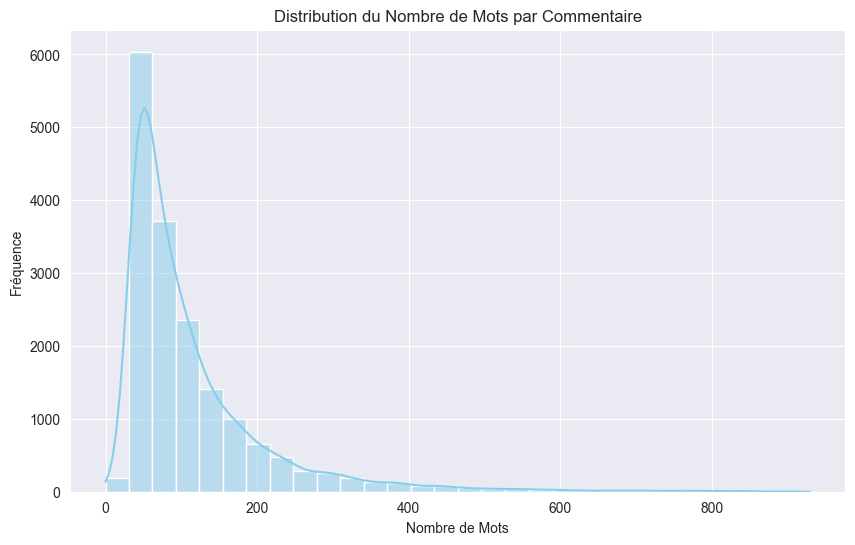

C:\Users\User\AppData\Local\Temp\ipykernel_10860\3472153579.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_games.index, y=top_games.values, palette='viridis')


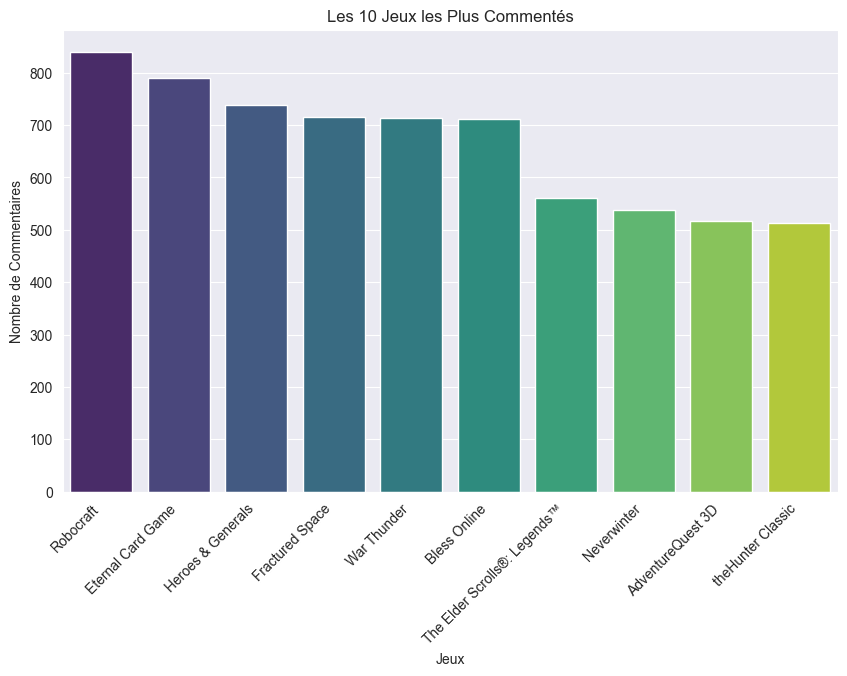

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Proportion de reviews positives et négatives
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='user_suggestion', palette='coolwarm')
plt.title('Proportion de Reviews Positives et Négatives')
plt.xlabel('User Suggestion (0 = Négatif, 1 = Positif)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Négatif', 'Positif'])
plt.show()

# 2. Nombre moyen de mots par commentaire
train_df['word_count'] = train_df['cleaned_review'].apply(lambda x: len(x.split()))

# Calcul du nombre moyen de mots
average_word_count = train_df['word_count'].mean()
print(f"Nombre moyen de mots par commentaire : {average_word_count}")

# Histogramme du nombre de mots par commentaire
plt.figure(figsize=(10, 6))
sns.histplot(train_df['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution du Nombre de Mots par Commentaire')
plt.xlabel('Nombre de Mots')
plt.ylabel('Fréquence')
plt.show()

# 3. Jeux les plus commentés
top_games = train_df['title'].value_counts().head(10)  # Les 10 jeux les plus commentés
plt.figure(figsize=(10, 6))
sns.barplot(x=top_games.index, y=top_games.values, palette='viridis')
plt.title('Les 10 Jeux les Plus Commentés')
plt.xlabel('Jeux')
plt.ylabel('Nombre de Commentaires')
plt.xticks(rotation=45, ha='right')
plt.show()

# Prétraitement exemple : Texte d'origine : "Les pommes sont rouges."

Tokenization ( Diviser un texte en unités plus petites (tokens)) ["Les", "pommes", "sont", "rouges"]

In [20]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

# Tokenisation des mots
train_df['tokens'] = train_df['cleaned_review'].apply(word_tokenize)

# Afficher un exemple
print(train_df['tokens'].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    [i, m, scared, hearing, creepy, voices, ., so,...
1    [best, game, ,, more, better, than, sam, peppe...
2    [a, littly, iffy, on, the, controls, ,, but, o...
3    [great, game, ,, fun, and, colorful, and, all,...
4    [not, many, games, have, cute, tag, right, nex...
Name: tokens, dtype: object


Suppression des Stop Words (Enlever les mots fréquents et peu informatifs (ex. "le", "la", "de", "et", etc.)) ["pommes", "rouges"]

In [21]:
from nltk.corpus import stopwords

# Télécharger les stopwords
nltk.download('stopwords')

# Filtrer les tokens pour supprimer les stopwords
stop_words = set(stopwords.words('french'))  # Ou 'english' pour les données en anglais

train_df['tokens_no_stopwords'] = train_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Afficher un exemple
print(train_df['tokens_no_stopwords'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [i, scared, hearing, creepy, voices, ., so, i,...
1    [best, game, ,, more, better, than, sam, peppe...
2    [a, littly, iffy, the, controls, ,, but, once,...
3    [great, game, ,, fun, and, colorful, and, all,...
4    [not, many, games, have, cute, tag, right, nex...
Name: tokens_no_stopwords, dtype: object


Lemmatisation (Réduire les mots à leur forme canonique ou de base) ["pomme", "rouge"]

In [22]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatisation des tokens
train_df['tokens_lemmatized'] = train_df['tokens_no_stopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Afficher un exemple
print(train_df['tokens_lemmatized'].head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [i, scared, hearing, creepy, voice, ., so, i, ...
1    [best, game, ,, more, better, than, sam, peppe...
2    [a, littly, iffy, the, control, ,, but, once, ...
3    [great, game, ,, fun, and, colorful, and, all,...
4    [not, many, game, have, cute, tag, right, next...
Name: tokens_lemmatized, dtype: object


Stemmatisation (Réduire les mots à leur racine)

In [23]:
from nltk.stem import PorterStemmer

# Initialisation du stemmer
stemmer = PorterStemmer()

# Stemmatisation des tokens
train_df['tokens_stemmed'] = train_df['tokens_no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

# Afficher un exemple
print(train_df['tokens_stemmed'].head())

0    [i, scare, hear, creepi, voic, ., so, i, ll, p...
1    [best, game, ,, more, better, than, sam, peppe...
2    [a, littli, iffi, the, control, ,, but, onc, y...
3    [great, game, ,, fun, and, color, and, all, th...
4    [not, mani, game, have, cute, tag, right, next...
Name: tokens_stemmed, dtype: object


Embeddings (Représentations vectorielles des mots)

In [24]:
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Charger le modèle pré-entraîné Word2Vec
model = api.load("word2vec-google-news-300")

# Initialiser le lemmatizer et la liste des stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Exemple de prétraitement et application des embeddings
def preprocess_and_embed(text):
    # Tokenisation
    tokens = word_tokenize(text.lower())

    # Suppression des stopwords
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    # Lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Générer les embeddings pour chaque token
    embeddings = [model[word] for word in tokens if word in model]

    # Retourner la moyenne des embeddings (ou toute autre opération que tu préfères)
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(300)  # Si aucun mot n'est dans le modèle, retourner un vecteur nul

# Appliquer la fonction à un texte
text = "The apples are red."
embedding = preprocess_and_embed(text)

print("Embedding moyen : ", embedding)

ModuleNotFoundError: No module named 'numpy.strings'